# Analysis

In [1]:
import pandas as pd
import numpy as np
import requests, time, json, io, datetime as dt
from pathlib import Path
import yaml
from itertools import chain
from datetime import datetime
import pyalex
from pyalex import Works, config
import yfinance as yf
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
# Data directories
DATA_DIR = Path("data")
RAW_OPENALEX_DIR = DATA_DIR / "raw" / "openalex"
RAW_OPENALEX_COUNTS_DIR = DATA_DIR / "raw" / "openalex_counts"
RAW_PRICES_DIR = DATA_DIR / "raw" / "prices"
PROCESSED_DIR = DATA_DIR / "processed"

In [3]:
with open("sector_map.yml", "r") as f:
    SECTOR_MAP = yaml.safe_load(f)

## Build features

Predictive features:   
1. pub_count (raw daily/weekly publications)  
2. pub_4w (rolling 4-week sum): Sustained increases (momentum in publications) could coincide with sector cycles or long-term interest. Smooths out daily noise, captures medium-term “buzz” trend.  
3. pub_growth (percent change in pub_count): It detects inflection points instead of levels. A surge in activity may be more relevant than a high but stable baseline.  
4. pub_z (z-score relative to 26-week mean/std): Extreme deviations (“publication shock” days) carry more signal than absolute counts. Normalizes across sectors/time, so a spike in semiconductors vs biotech is comparable. Also flags outliers relative to history.  
5. close_mean: equal-weight average of the tickers’ closing prices (from Stooq)
6. ret_1d: daily return (average across tickers).
7. ret_fwd_5d: forward 5-day return (average across tickers).  
8. volume_sum: The total trading volume across all tickers in the sector for a given day  
9. vol_4w: Rolling 4-week (≈20 trading days) sum of volume_sum  
10. vol_growth: Day-over-day percentage change in volume_sum  
11. vol_z: A z-score standardized anomaly measure of volume relative to its 6-month history (≈126 trading days).  

Target:  
y_up_5d (label: 1 if 5-day return positive)  
Why 5 days? Publications move slowly; daily returns are noisy. A weekly horizon balances signal and tradability.  
Purpose: Gives you a binary prediction problem: “Does literature signal the next week’s direction?”  

In [23]:
def _map_calendar_to_trading(left_df, left_date_col, px_dates, tolerance_days=4):
    trade_ref = px_dates[["date"]].rename(columns={"date":"trade_date"}).sort_values("trade_date")
    mapped = pd.merge_asof(
        left=left_df.sort_values(left_date_col),
        right=trade_ref,
        left_on=left_date_col,
        right_on="trade_date",
        direction="forward",
        tolerance=pd.Timedelta(days=tolerance_days),
    )
    return mapped.dropna(subset=["trade_date"])

def _topic_counts_to_topN_wide(counts_df, time_col, N=5):
    if counts_df.empty:
        topic_cols = [f"top{i}" for i in range(1, N+1)]
        count_cols = [f"top{i}_count" for i in range(1, N+1)]
        return pd.DataFrame(columns=[time_col] + topic_cols + count_cols + ["top_list"])

    topN = (counts_df
            .sort_values([time_col, "count", "topic"], ascending=[True, False, True])
            .groupby(time_col, as_index=False)
            .head(N)
            .copy())
    topN["rank"] = topN.groupby(time_col)["count"].rank(method="first", ascending=False).astype(int)

    topN["k_topic"] = "top" + topN["rank"].astype(str)
    topN["k_count"] = topN["k_topic"] + "_count"

    T = (topN.pivot(index=time_col, columns="k_topic", values="topic")
              .reset_index().rename_axis(None, axis=1))
    C = (topN.pivot(index=time_col, columns="k_count", values="count")
              .reset_index().rename_axis(None, axis=1))
    W = T.merge(C, on=time_col, how="outer")

    topic_cols = [f"top{i}" for i in range(1, N+1)]
    count_cols = [f"top{i}_count" for i in range(1, N+1)]
    for col in topic_cols + count_cols:
        if col not in W.columns:
            W[col] = pd.NA
    W = W[[time_col] + topic_cols + count_cols]
    W["top_list"] = (W[topic_cols].fillna("")
                     .apply(lambda r: "|".join([t for t in r if t]), axis=1))
    return W

def build_features_from_topics(sector: str,
                               window_z_days=126,
                               forward_tolerance_days=4,
                               topN=5,
                               include_topic_wide=True):
    """
    Build features using Topic-derived outputs:
      • Loads prices: RAW_PRICES_DIR/sector_{sector}_daily_agg.csv
      • Loads topics wide: PROCESSED_DIR/topics/daily_top5_wide_{sector}.csv
      • Optionally loads per-topic daily counts: PROCESSED_DIR/topics/daily_topic_counts_{sector}.csv
      • Maps calendar pub dates → next trading day; zero-fills missing trading days with pub_count=0
      • Computes features (+ cleans ±∞ across ALL numeric columns before saving)
      • Writes PROCESSED_DIR/features_{sector}.csv
    """
    # ---- Paths
    px_path      = RAW_PRICES_DIR / f"sector_{sector}_daily_agg.csv"
    wide_path    = PROCESSED_DIR  / "topics" / f"daily_top5_wide_{sector}.csv"
    counts_path  = PROCESSED_DIR  / "topics" / f"daily_topic_counts_{sector}.csv"

    if not px_path.exists():
        raise FileNotFoundError(f"Missing price file: {px_path}")
    if not wide_path.exists():
        raise FileNotFoundError(f"Missing topics wide file: {wide_path}. Run topic extraction first.")

    # ---- Load
    px   = pd.read_csv(px_path, parse_dates=["date"]).sort_values("date").reset_index(drop=True)
    wide = pd.read_csv(wide_path, parse_dates=["date"]).sort_values("date").reset_index(drop=True)

    # ---- 1) Map total publications (calendar) → trading day and aggregate
    total_pub_calendar = wide[["date", "total_publications"]].dropna()
    mapped_total = _map_calendar_to_trading(total_pub_calendar, "date", px, tolerance_days=forward_tolerance_days)

    pub_trading = (mapped_total.groupby("trade_date", as_index=False)["total_publications"]
                   .sum()
                   .rename(columns={"trade_date":"date", "total_publications":"pub_count"}))

    # ---- 2) Zero-fill missing trading days
    all_trading_dates = px[["date"]].copy()
    pub_trading = all_trading_dates.merge(pub_trading, on="date", how="left")
    pub_trading["pub_count"] = pub_trading["pub_count"].fillna(0).astype(int)

    # ---- 3) Merge pubs with prices
    df = (pub_trading.merge(px, on="date", how="left")
                    .sort_values("date")
                    .reset_index(drop=True))

    # ---- Helpers for safe growth/z computations
    def safe_pct_change(s: pd.Series):
        pc = s.pct_change()
        return pc.replace([np.inf, -np.inf], np.nan)

    # ---- 4) Rolling features (safe)
    df["pub_4w"]     = df["pub_count"].rolling(20, min_periods=5).sum()
    df["pub_growth"] = safe_pct_change(df["pub_count"])
    roll_mean = df["pub_count"].rolling(window_z_days, min_periods=30).mean()
    roll_std  = df["pub_count"].rolling(window_z_days, min_periods=30).std()
    df["pub_z"] = (df["pub_count"] - roll_mean) / roll_std

    # ---- 5) Label
    df["y_up_5d"] = (df["ret_fwd_5d"] > 0).astype("Int64")

    # ---- 6) Optional: trading-day Top-N topics and shares (guard against div/0)
    if include_topic_wide and counts_path.exists():
        dcounts = pd.read_csv(counts_path, parse_dates=["date"])
        mapped_counts = _map_calendar_to_trading(dcounts, "date", px, tolerance_days=forward_tolerance_days)
        trade_topic_counts = (mapped_counts
                              .groupby(["trade_date","topic"], as_index=False)["count"].sum()
                              .rename(columns={"trade_date":"date"}))
        topN_wide_trade = _topic_counts_to_topN_wide(trade_topic_counts, time_col="date", N=topN)

        # Merge true totals (pub_count) and compute shares safely
        topN_wide_trade = topN_wide_trade.merge(
            df[["date","pub_count"]].rename(columns={"pub_count":"total_publications"}),
            on="date", how="left"
        )
        denom = topN_wide_trade["total_publications"].astype(float)
        denom = denom.where(denom > 0)  # NaN when 0 or NaN

        for i in range(1, topN+1):
            ccol = f"top{i}_count"
            scol = f"top{i}_share"
            if ccol in topN_wide_trade.columns:
                num = topN_wide_trade[ccol].astype(float)
                topN_wide_trade[scol] = (num / denom)

        topic_cols = [f"top{i}" for i in range(1, topN+1)]
        if not set(topic_cols).issubset(topN_wide_trade.columns):
            for c in topic_cols:
                if c not in topN_wide_trade.columns:
                    topN_wide_trade[c] = pd.NA
        topN_wide_trade["top_list"] = (topN_wide_trade[topic_cols]
                                       .fillna("")
                                       .apply(lambda r: "|".join([t for t in r if t]), axis=1))

        keep_cols = (["date"] + topic_cols +
                     [f"top{i}_count" for i in range(1, topN+1)] +
                     ["total_publications"] +
                     [f"top{i}_share" for i in range(1, topN+1)] +
                     ["top_list"])
        df = df.merge(topN_wide_trade[keep_cols], on="date", how="left")

    elif include_topic_wide:
        mapped_wide = _map_calendar_to_trading(wide, "date", px, tolerance_days=forward_tolerance_days)
        name_cols  = [f"top{i}" for i in range(1, 6)]
        count_cols = [f"top{i}_count" for i in range(1, 6)]
        agg_spec = {c: "sum" for c in count_cols}
        for c in name_cols:
            agg_spec[c] = "last"
        agg_spec["total_publications"] = "sum"
        tmp = (mapped_wide
               .groupby("trade_date", as_index=False)
               .agg(agg_spec)
               .rename(columns={"trade_date":"date"}))

        # Replace totals with canonical pub_count and compute shares safely
        tmp = tmp.merge(df[["date","pub_count"]].rename(columns={"pub_count":"total_publications"}), on="date", how="left")
        denom = tmp["total_publications"].astype(float)
        denom = denom.where(denom > 0)

        for i in range(1, 6):
            ccol, scol = f"top{i}_count", f"top{i}_share"
            if ccol in tmp.columns:
                num = tmp[ccol].astype(float)
                tmp[scol] = (num / denom)

        tmp["top_list"] = (tmp[name_cols].fillna("")
                           .apply(lambda r: "|".join([t for t in r if t]), axis=1))

        keep = ["date"] + name_cols + count_cols + ["total_publications"] + \
               [f"top{i}_share" for i in range(1, 6)] + ["top_list"]
        df = df.merge(tmp[keep], on="date", how="left")

    # ---- 7) FINAL CLEANUP: replace any ±∞ with NaN across ALL numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

    # ---- 8) Save
    out = PROCESSED_DIR / f"features_{sector}.csv"
    df.to_csv(out, index=False)
    print(f"[{sector}] features_from_topics → {out} | rows={len(df)} | NaN counts:",
          df[num_cols].isna().sum().to_dict())
    return df

# ---- Rebuild for all sectors (cleans infinities for each)
_ = [build_features_from_topics(s) for s in SECTOR_MAP.keys()]

[Biotech] features_from_topics → data/processed/features_Biotech.csv | rows=165 | NaN counts: {'pub_count': 0, 'close_mean': 0, 'ret_1d': 1, 'ret_fwd_5d': 5, 'volume_sum': 0, 'vol_4w': 4, 'vol_growth': 1, 'vol_z': 29, 'pub_4w': 4, 'pub_growth': 17, 'pub_z': 29, 'y_up_5d': 0, 'top1_count': 16, 'top2_count': 17, 'top3_count': 17, 'top4_count': 48, 'top5_count': 64, 'total_publications': 16, 'top1_share': 16, 'top2_share': 17, 'top3_share': 17, 'top4_share': 48, 'top5_share': 64}
[Semiconductors] features_from_topics → data/processed/features_Semiconductors.csv | rows=165 | NaN counts: {'pub_count': 0, 'close_mean': 0, 'ret_1d': 1, 'ret_fwd_5d': 5, 'volume_sum': 0, 'vol_4w': 4, 'vol_growth': 1, 'vol_z': 29, 'pub_4w': 4, 'pub_growth': 2, 'pub_z': 29, 'y_up_5d': 0, 'top1_count': 1, 'top2_count': 1, 'top3_count': 2, 'top4_count': 8, 'top5_count': 13, 'total_publications': 1, 'top1_share': 1, 'top2_share': 1, 'top3_share': 2, 'top4_share': 8, 'top5_share': 13}


In [9]:
sector = "Biotech"  # change as needed
px_path   = RAW_PRICES_DIR / f"sector_{sector}_daily_agg.csv"
feat_path = PROCESSED_DIR   / f"features_{sector}.csv"

px   = pd.read_csv(px_path, parse_dates=["date"])
print("px cols:", px.columns.tolist())

# if file already exists, peek at what was saved
import os
if os.path.exists(feat_path):
    feat = pd.read_csv(feat_path, nrows=3)
    print("features cols (saved file):", feat.columns.tolist())


px cols: ['date', 'close_mean', 'ret_1d', 'ret_fwd_5d', 'volume_sum', 'vol_4w', 'vol_growth', 'vol_z']
features cols (saved file): ['date', 'pub_count', 'close_mean', 'ret_1d', 'ret_fwd_5d', 'volume_sum', 'vol_4w', 'vol_growth', 'vol_z', 'pub_4w', 'pub_growth', 'pub_z', 'y_up_5d', 'top1', 'top2', 'top3', 'top4', 'top5', 'top1_count', 'top2_count', 'top3_count', 'top4_count', 'top5_count', 'total_publications', 'top1_share', 'top2_share', 'top3_share', 'top4_share', 'top5_share', 'top_list']


## EDA

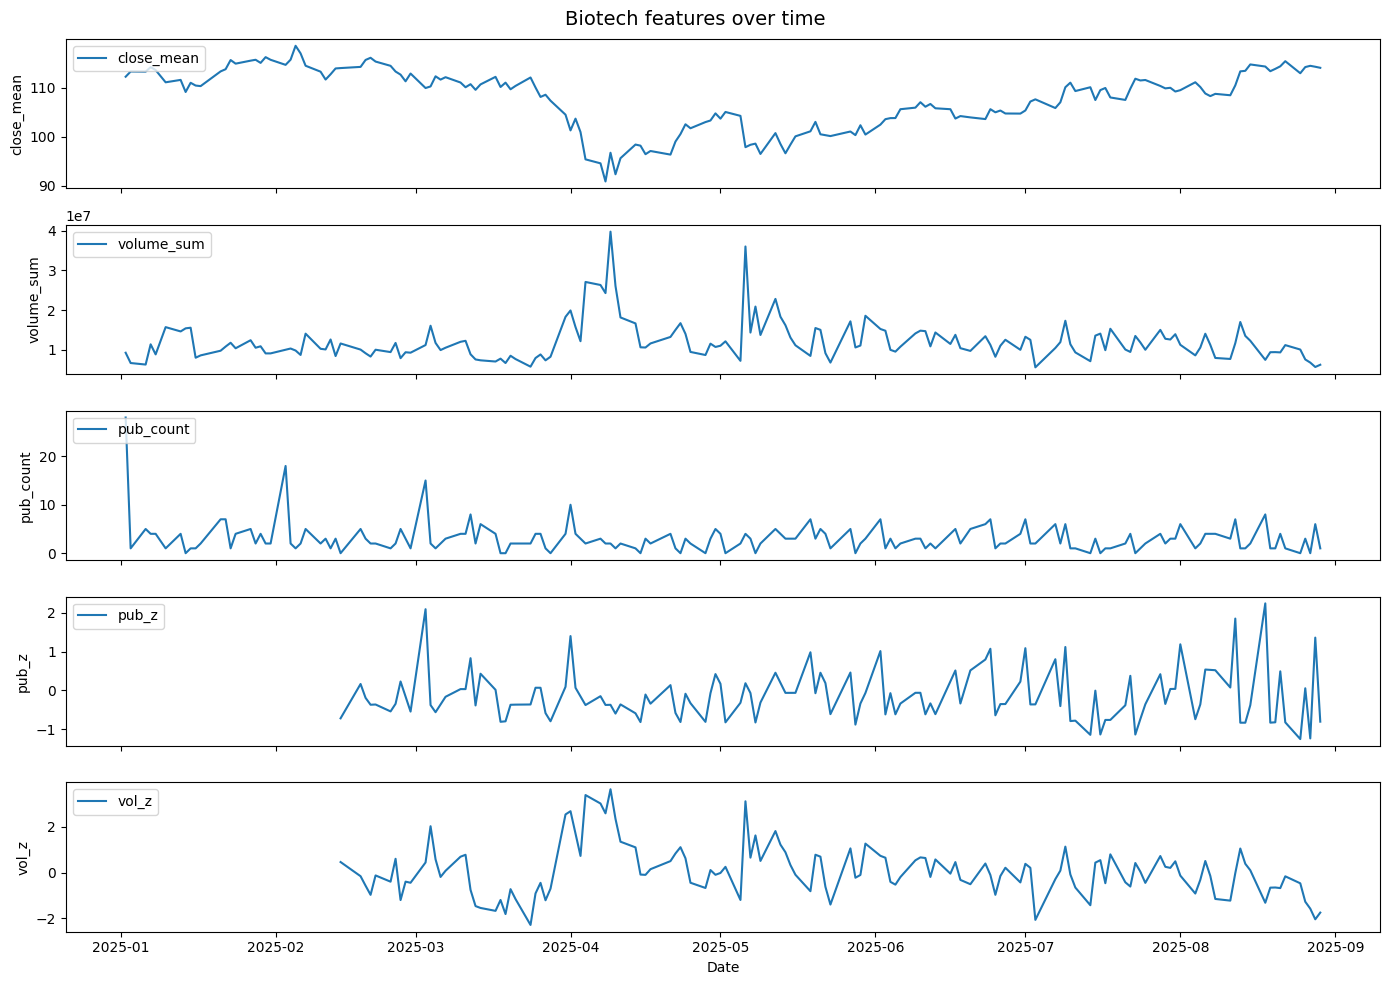

In [24]:
import matplotlib.pyplot as plt

sector = "Biotech"  # change as needed
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", parse_dates=["date"])

# Pick some representative features to plot
cols = ["close_mean","volume_sum","pub_count","pub_z","vol_z"]

fig, axes = plt.subplots(len(cols), 1, figsize=(14, 10), sharex=True)
for ax, c in zip(axes, cols):
    ax.plot(feat["date"], feat[c], label=c)
    ax.set_ylabel(c)
    ax.legend(loc="upper left")
axes[-1].set_xlabel("Date")
plt.suptitle(f"{sector} features over time", fontsize=14)
plt.tight_layout()
plt.show()


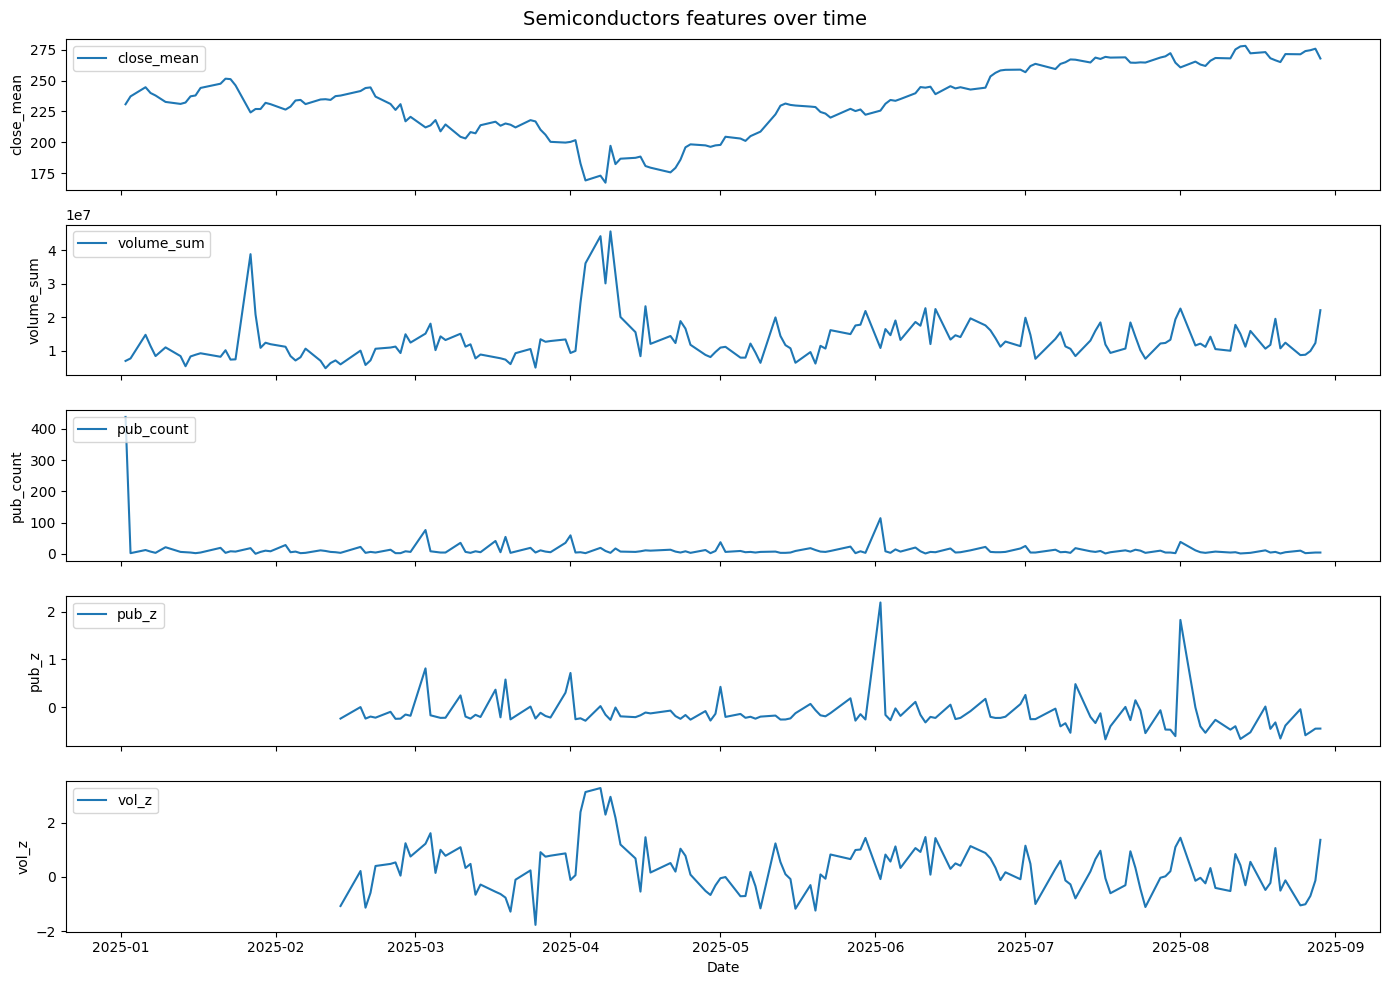

In [43]:
import matplotlib.pyplot as plt

sector = "Semiconductors"  # change as needed
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", parse_dates=["date"])

# Pick some representative features to plot
cols = ["close_mean","volume_sum","pub_count","pub_z","vol_z"]

fig, axes = plt.subplots(len(cols), 1, figsize=(14, 10), sharex=True)
for ax, c in zip(axes, cols):
    ax.plot(feat["date"], feat[c], label=c)
    ax.set_ylabel(c)
    ax.legend(loc="upper left")
axes[-1].set_xlabel("Date")
plt.suptitle(f"{sector} features over time", fontsize=14)
plt.tight_layout()
plt.show()


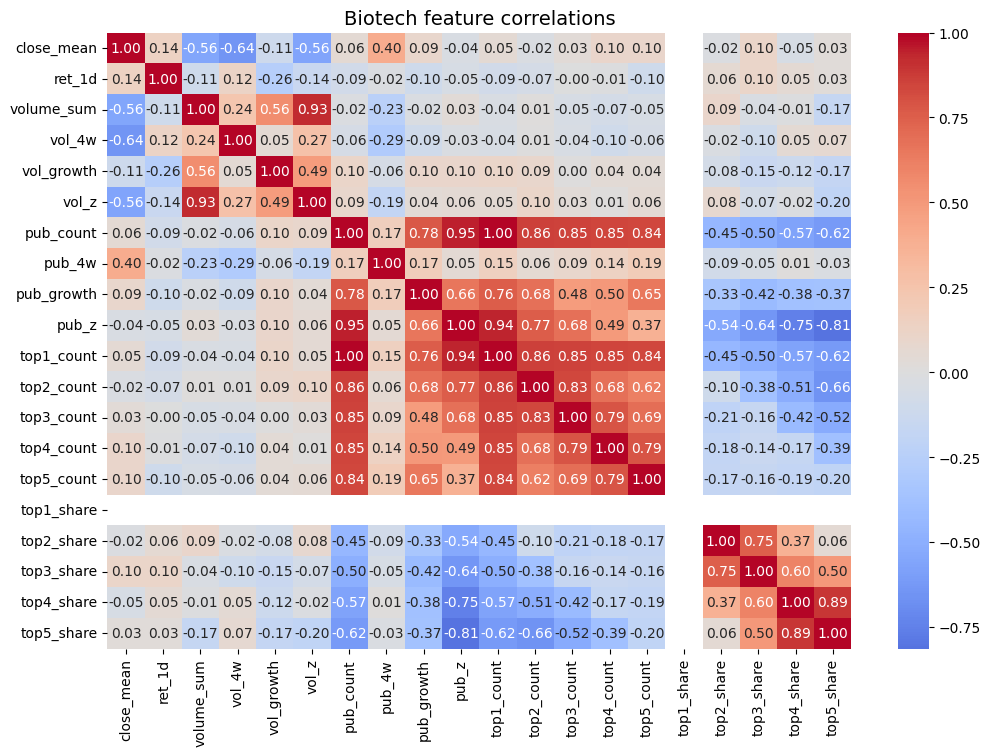

In [ ]:
import seaborn as sns

sector = "Biotech"  # change as needed
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", parse_dates=["date"])

# Select numeric features only
num_cols = ["close_mean","ret_1d",
            "volume_sum","vol_4w","vol_growth","vol_z",
            "pub_count","pub_4w","pub_growth","pub_z",
            "top1_count","top2_count","top3_count","top4_count","top5_count",
            "top1_share","top2_share","top3_share","top4_share","top5_share"]

corr = feat[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(f"{sector} feature correlations", fontsize=14)
plt.show()
# "ret_fwd_5d" calculate target, forward looking

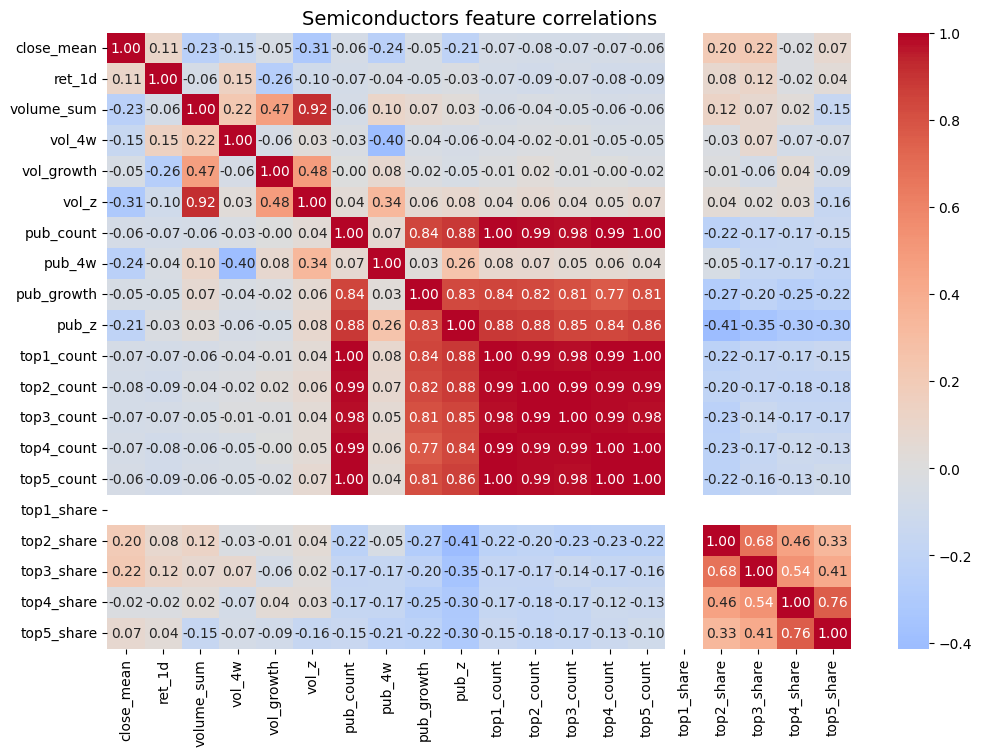

In [52]:
import seaborn as sns

sector = "Semiconductors"  # change as needed
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", parse_dates=["date"])

# Select numeric features only
num_cols = ["close_mean","ret_1d",
            "volume_sum","vol_4w","vol_growth","vol_z",
            "pub_count","pub_4w","pub_growth","pub_z",
            "top1_count","top2_count","top3_count","top4_count","top5_count",
            "top1_share","top2_share","top3_share","top4_share","top5_share"]

corr = feat[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(f"{sector} feature correlations", fontsize=14)
plt.show()
# "ret_fwd_5d" calculate target, forward looking


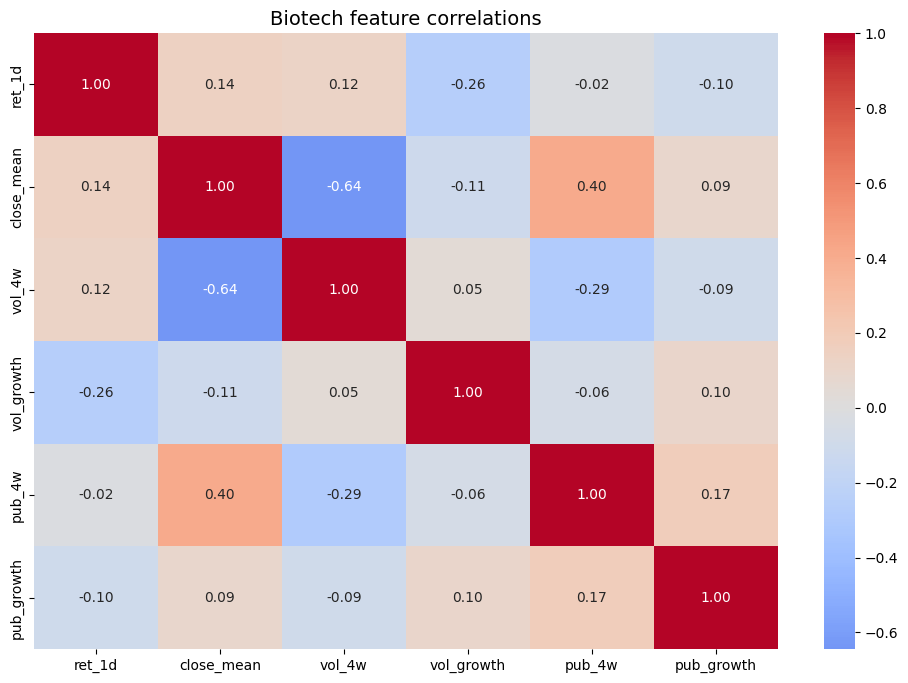

In [56]:
sector = "Biotech"  # change as needed
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", parse_dates=["date"])

num_cols = ["ret_1d","close_mean",
            "vol_4w","vol_growth",
            "pub_4w","pub_growth",
            ]

corr = feat[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(f"{sector} feature correlations", fontsize=14)
plt.show()
# "pub_count","pub_z",
# "top1_count","top3_count","top2_count","top4_count","top5_count",
# "top1_share","top3_share","top5_share","top4_share","top2_share",
# "volume_sum","vol_z",

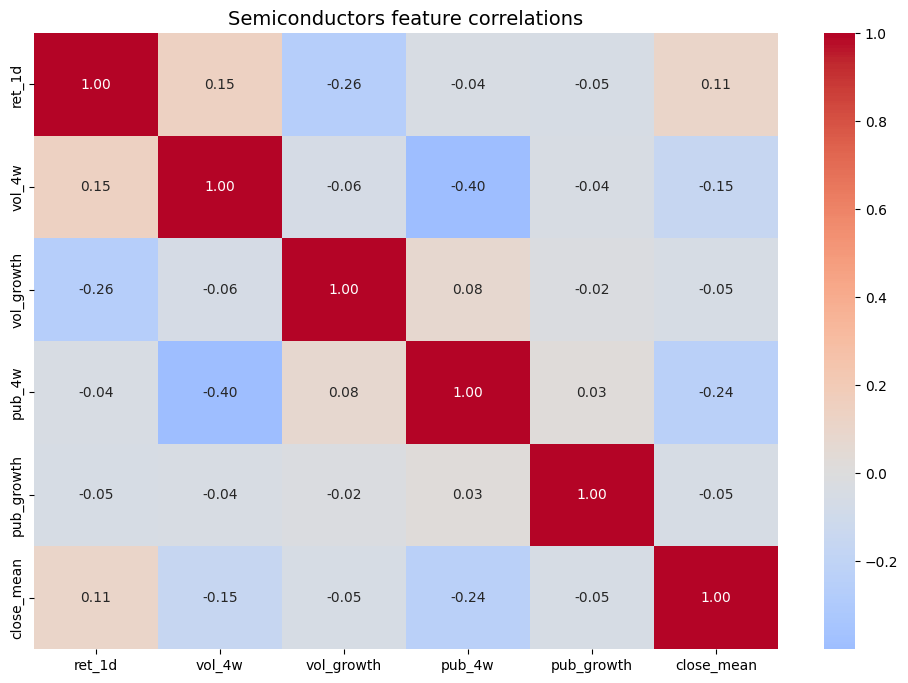

In [55]:
sector = "Semiconductors"  # change as needed
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", parse_dates=["date"])

num_cols = ["ret_1d",
            "vol_4w","vol_growth",
            "pub_4w","pub_growth","close_mean"
            ]

corr = feat[num_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title(f"{sector} feature correlations", fontsize=14)
plt.show()
# "pub_count","pub_z",
# "top1_count","top3_count","top2_count","top4_count","top5_count",
# "top1_share","top3_share","top5_share","top4_share","top2_share",
# "volume_sum",,"vol_z",

## Model

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

sector = "Biotech"  # change as needed
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", parse_dates=["date"])
# Columns for modeling
feature_cols = ["ret_1d","close_mean",
                "vol_4w","vol_growth",
                "pub_4w","pub_growth",]
label_col = "y_up_5d"

# Keep only rows that have a label
d = feat.dropna(subset=[label_col]).copy()

# Build X, y; clean ±inf -> NaN
X = d[feature_cols].replace([np.inf, -np.inf], np.nan)
y = d[label_col].astype(int).values

# ---- Time-based split (70/30) ----
split = int(0.7 * len(d))
X_train_raw, X_test_raw = X.iloc[:split].copy(), X.iloc[split:].copy()
y_train, y_test = y[:split], y[split:]

# ---- Impute (median) using TRAIN stats only ----
imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train_raw)
X_test_imp  = imp.transform(X_test_raw)

# ---- Train-only winsorization (clip extremes) ----
# Use percentiles for stability (e.g., 0.5% / 99.5%)
q_low  = np.nanpercentile(X_train_imp,  0.5, axis=0)
q_high = np.nanpercentile(X_train_imp, 99.5, axis=0)

# Clip using train thresholds
X_train_clip = np.clip(X_train_imp, q_low, q_high)
X_test_clip  = np.clip(X_test_imp,  q_low, q_high)

# ---- Scale (fit on train, apply to test) ----
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_clip)
X_test  = scaler.transform(X_test_clip)

# ---- Model: balanced Logistic Regression ----
clf = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000, class_weight="balanced")
clf.fit(X_train, y_train)

# ---- Evaluate ----
p_test = clf.predict_proba(X_test)[:, 1]
preds  = (p_test > 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, p_test))
print(classification_report(y_test, preds, digits=3))

# ---- Coefficient view (importance proxy) ----
coef = pd.Series(clf.coef_[0], index=feature_cols).sort_values(key=np.abs, ascending=False)
display(coef.to_frame("logit_coef"))

ROC AUC: 0.7116666666666667
              precision    recall  f1-score   support

           0      0.487     0.950     0.644        20
           1      0.909     0.333     0.488        30

    accuracy                          0.580        50
   macro avg      0.698     0.642     0.566        50
weighted avg      0.740     0.580     0.550        50



,logit_coef
close_mean,-1.109162
pub_growth,0.237375
vol_growth,-0.212396
vol_4w,-0.207392
pub_4w,0.196846
ret_1d,-0.018540


In [66]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[
    ("pre", SimpleImputer(strategy="median")),  # RF doesn't need scaling
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
p_test_rf = rf.predict_proba(X_test)[:,1]
preds_rf  = (p_test_rf > 0.5).astype(int)

print("RF ROC AUC:", roc_auc_score(y_test, p_test_rf))
print(classification_report(y_test, preds_rf, digits=3))


RF ROC AUC: 0.4766666666666667
              precision    recall  f1-score   support

           0      0.408     1.000     0.580        20
           1      1.000     0.033     0.065        30

    accuracy                          0.420        50
   macro avg      0.704     0.517     0.322        50
weighted avg      0.763     0.420     0.271        50



In [59]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

sector = "Semiconductors"  # change as needed
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", parse_dates=["date"])

# Columns for modeling
feature_cols = ["ret_1d","close_mean",
                "vol_4w","vol_growth",
                "pub_4w","pub_growth",]
label_col = "y_up_5d"

# Keep only rows that have a label
d = feat.dropna(subset=[label_col]).copy()

# Build X, y; clean ±inf -> NaN
X = d[feature_cols].replace([np.inf, -np.inf], np.nan)
y = d[label_col].astype(int).values

# ---- Time-based split (70/30) ----
split = int(0.7 * len(d))
X_train_raw, X_test_raw = X.iloc[:split].copy(), X.iloc[split:].copy()
y_train, y_test = y[:split], y[split:]

# ---- Impute (median) using TRAIN stats only ----
imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train_raw)
X_test_imp  = imp.transform(X_test_raw)

# ---- Train-only winsorization (clip extremes) ----
# Use percentiles for stability (e.g., 0.5% / 99.5%)
q_low  = np.nanpercentile(X_train_imp,  0.5, axis=0)
q_high = np.nanpercentile(X_train_imp, 99.5, axis=0)

# Clip using train thresholds
X_train_clip = np.clip(X_train_imp, q_low, q_high)
X_test_clip  = np.clip(X_test_imp,  q_low, q_high)

# ---- Scale (fit on train, apply to test) ----
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_clip)
X_test  = scaler.transform(X_test_clip)

# ---- Model: balanced Logistic Regression ----
clf = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000, class_weight="balanced")
clf.fit(X_train, y_train)

# ---- Evaluate ----
p_test = clf.predict_proba(X_test)[:, 1]
preds  = (p_test > 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, p_test))
print(classification_report(y_test, preds, digits=3))

# ---- Coefficient view (importance proxy) ----
coef = pd.Series(clf.coef_[0], index=feature_cols).sort_values(key=np.abs, ascending=False)
display(coef.to_frame("logit_coef"))

ROC AUC: 0.7832512315270936
              precision    recall  f1-score   support

           0      0.727     0.381     0.500        21
           1      0.667     0.897     0.765        29

    accuracy                          0.680        50
   macro avg      0.697     0.639     0.632        50
weighted avg      0.692     0.680     0.654        50



,logit_coef
vol_4w,0.738645
pub_4w,0.368178
vol_growth,0.148390
close_mean,0.103480
ret_1d,-0.012063
pub_growth,0.011227


In [60]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[
    ("pre", SimpleImputer(strategy="median")),  # RF doesn't need scaling
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
p_test_rf = rf.predict_proba(X_test)[:,1]
preds_rf  = (p_test_rf > 0.5).astype(int)

print("RF ROC AUC:", roc_auc_score(y_test, p_test_rf))
print(classification_report(y_test, preds_rf, digits=3))


RF ROC AUC: 0.6403940886699507
              precision    recall  f1-score   support

           0      0.545     0.286     0.375        21
           1      0.615     0.828     0.706        29

    accuracy                          0.600        50
   macro avg      0.580     0.557     0.540        50
weighted avg      0.586     0.600     0.567        50



## Add categroical features

### Preserve rank

In [68]:
import numpy as np, pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

sector = "Biotech"  # change
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", encoding="utf-8-sig")

# ----- Numeric features (safe set; feel free to add/remove) -----
num_cols = ["ret_1d","close_mean",
                "vol_4w","vol_growth",
                "pub_4w","pub_growth",]

# ----- Categorical topic name columns (Top-1..Top-5) -----
cat_cols = ["top1","top2","top3","top4","top5"]

# Keep rows that have a label; replace ±inf in numerics with NaN
label_col = "y_up_5d"
d = feat.dropna(subset=[label_col]).copy()
for c in num_cols:
    if c in d.columns:
        d[c] = d[c].replace([np.inf, -np.inf], np.nan)

# Split by time (70/30)
split = int(0.7 * len(d))
train, test = d.iloc[:split].copy(), d.iloc[split:].copy()
y_train = train[label_col].astype(int).values
y_test  = test[label_col].astype(int).values

# Column-wise preprocessing
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])

# For topics: impute missing label to "MISSING", then one-hot; min_frequency groups rare levels
categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=5)),  # drop min_frequency if you want full granularity
])

pre = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, [c for c in num_cols if c in train.columns]),
        ("cat", categorical_pipe, [c for c in cat_cols if c in train.columns]),
    ],
    remainder="drop",
)

# --------- Baseline 1: Logistic Regression ----------
logit = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=2000
    ))
])

logit.fit(train, y_train)
p_logit = logit.predict_proba(test)[:,1]
print("[Logit] ROC AUC:", roc_auc_score(y_test, p_logit))
print(classification_report(y_test, (p_logit>0.5).astype(int), digits=3))

# --------- Baseline 2: Random Forest ----------
rf = Pipeline([
    ("pre", pre),  # impute + OHE; RF doesn't need scaling for nums, but it's fine
    ("clf", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1,
        oob_score=True
    ))
])

rf.fit(train, y_train)
p_rf = rf.predict_proba(test)[:,1]
print("[RF] ROC AUC:", roc_auc_score(y_test, p_rf))
print(classification_report(y_test, (p_rf>0.5).astype(int), digits=3))


[Logit] ROC AUC: 0.5916666666666666
              precision    recall  f1-score   support

           0      0.457     0.800     0.582        20
           1      0.733     0.367     0.489        30

    accuracy                          0.540        50
   macro avg      0.595     0.583     0.535        50
weighted avg      0.623     0.540     0.526        50

[RF] ROC AUC: 0.4066666666666666
              precision    recall  f1-score   support

           0      0.400     0.900     0.554        20
           1      0.600     0.100     0.171        30

    accuracy                          0.420        50
   macro avg      0.500     0.500     0.363        50
weighted avg      0.520     0.420     0.324        50



In [75]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

sector = "Semiconductors"  # change
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", encoding="utf-8-sig")

# ----- Numeric features (safe set; feel free to add/remove) -----
num_cols = ["ret_1d","close_mean",
            "vol_4w","vol_growth",
            "pub_4w","pub_growth",]

# ----- Categorical topic name columns (Top-1..Top-5) -----
cat_cols = ["top1","top2","top3","top4","top5"]

# Keep rows that have a label; replace ±inf in numerics with NaN
label_col = "y_up_5d"
d = feat.dropna(subset=[label_col]).copy()
for c in num_cols:
    if c in d.columns:
        d[c] = d[c].replace([np.inf, -np.inf], np.nan)

# Split by time (70/30)
split = int(0.7 * len(d))
train, test = d.iloc[:split].copy(), d.iloc[split:].copy()
y_train = train[label_col].astype(int).values
y_test  = test[label_col].astype(int).values

# Column-wise preprocessing
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", min_frequency=5)),
])

pre = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, [c for c in num_cols if c in train.columns]),
        ("cat", categorical_pipe, [c for c in cat_cols if c in train.columns]),
    ],
    remainder="drop",
)

# --------- Baseline 1: Logistic Regression ----------
logit = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        class_weight="balanced",
        max_iter=2000
    ))
])

logit.fit(train, y_train)
p_logit = logit.predict_proba(test)[:,1]
print("[Logit] ROC AUC:", roc_auc_score(y_test, p_logit))
print(classification_report(y_test, (p_logit>0.5).astype(int), digits=3))

# --------- Baseline 2: Random Forest ----------
rf = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1,
        oob_score=True
    ))
])

rf.fit(train, y_train)
p_rf = rf.predict_proba(test)[:,1]
print("[RF] ROC AUC:", roc_auc_score(y_test, p_rf))
print(classification_report(y_test, (p_rf>0.5).astype(int), digits=3))

# --------- Feature Importances ----------
# Recover transformed feature names
def get_feature_names(preprocessor):
    output = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps"):
            # pipeline inside ColumnTransformer
            last = list(trans.named_steps.values())[-1]
            if hasattr(last, "get_feature_names_out"):
                fn = last.get_feature_names_out(cols)
                output.extend(fn)
            else:
                output.extend(cols)
        elif hasattr(trans, "get_feature_names_out"):
            fn = trans.get_feature_names_out(cols)
            output.extend(fn)
        else:
            output.extend(cols)
    return output

feat_names = get_feature_names(pre)

# Logistic regression coefficients
coef_logit = pd.Series(logit.named_steps["clf"].coef_[0], index=feat_names)
print("\n[Logit] Top coefficients:")
display(coef_logit.sort_values(key=np.abs, ascending=False).head(20).to_frame("logit_coef"))

# Random forest importances
imp_rf = pd.Series(rf.named_steps["clf"].feature_importances_, index=feat_names)
print("\n[RF] Top feature importances:")
display(imp_rf.sort_values(ascending=False).head(20).to_frame("rf_importance"))


[Logit] ROC AUC: 0.6535303776683088
              precision    recall  f1-score   support

           0      0.636     0.333     0.438        21
           1      0.641     0.862     0.735        29

    accuracy                          0.640        50
   macro avg      0.639     0.598     0.586        50
weighted avg      0.639     0.640     0.610        50

[RF] ROC AUC: 0.7044334975369458
              precision    recall  f1-score   support

           0      0.727     0.381     0.500        21
           1      0.667     0.897     0.765        29

    accuracy                          0.680        50
   macro avg      0.697     0.639     0.632        50
weighted avg      0.692     0.680     0.654        50


[Logit] Top coefficients:


,logit_coef
top3_Advancements in Semiconductor Devices and Circuit Design,-1.146551
top5_MISSING,1.036417
vol_4w,0.940845
top5_Advancements in Semiconductor Devices and Circuit Design,-0.919938
top3_Semiconductor Quantum Structures and Devices,0.731771
top5_Semiconductor Quantum Structures and Devices,-0.641825
top2_Semiconductor materials and devices,0.592635
top4_Advancements in Semiconductor Devices and Circuit Design,-0.562476
top3_Acoustic Wave Resonator Technologies,0.556083
pub_4w,0.445537



[RF] Top feature importances:


,rf_importance
vol_4w,0.238142
pub_4w,0.158885
close_mean,0.126679
ret_1d,0.093998
pub_growth,0.082782
vol_growth,0.081942
top3_Semiconductor Quantum Structures and Devices,0.033298
top2_Semiconductor materials and devices,0.019138
top3_infrequent_sklearn,0.018422
top2_Ga2O3 and related materials,0.016515


### Ignore encode

In [71]:
import numpy as np, pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

sector = "Biotech"
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", encoding="utf-8-sig")

num_cols = ["ret_1d","close_mean",
                "vol_4w","vol_growth",
                "pub_4w","pub_growth",]

# Build a list-of-topics column from top1..top5 (drop NaNs/empties)
def row_topics(row):
    vals = [row.get(f"top{i}") for i in range(1,6)]
    return [v for v in vals if isinstance(v, str) and v.strip()]

feat["topic_list"] = feat.apply(row_topics, axis=1)

label_col = "y_up_5d"
d = feat.dropna(subset=[label_col]).copy()
for c in num_cols:
    if c in d.columns:
        d[c] = d[c].replace([np.inf, -np.inf], np.nan)

# Train/test by time
split = int(0.7*len(d))
train, test = d.iloc[:split].copy(), d.iloc[split:].copy()
y_train = train[label_col].astype(int).values
y_test  = test[label_col].astype(int).values

# MultiLabelBinarizer fit on TRAIN ONLY (avoid leakage of rare labels)
mlb = MultiLabelBinarizer(sparse_output=False)
Z_train = mlb.fit_transform(train["topic_list"])
Z_test  = mlb.transform(test["topic_list"])

# Numeric preprocess
imp = SimpleImputer(strategy="median")
scaler = StandardScaler()

Xn_train = scaler.fit_transform(imp.fit_transform(train[[c for c in num_cols if c in train.columns]]))
Xn_test  = scaler.transform(imp.transform(test[[c for c in num_cols if c in test.columns]]))

# Concatenate numeric + topic one-hot
X_train = np.hstack([Xn_train, Z_train])
X_test  = np.hstack([Xn_test, Z_test])

# Train a baseline logistic
clf = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000, class_weight="balanced")
clf.fit(X_train, y_train)
p = clf.predict_proba(X_test)[:,1]
print("[Logit + BagTopics] ROC AUC:", roc_auc_score(y_test, p))
print(classification_report(y_test, (p>0.5).astype(int), digits=3))

# Optional: see the most predictive topics (by coef magnitude)
topic_names = [f"topic::{t}" for t in mlb.classes_]
num_names = [c for c in num_cols if c in train.columns]
names = num_names + topic_names
imp_series = pd.Series(clf.coef_[0], index=names).sort_values(key=np.abs, ascending=False)
display(imp_series.head(20).to_frame("logit_coef"))


[Logit + BagTopics] ROC AUC: 0.705
              precision    recall  f1-score   support

           0      0.500     0.850     0.630        20
           1      0.812     0.433     0.565        30

    accuracy                          0.600        50
   macro avg      0.656     0.642     0.597        50
weighted avg      0.688     0.600     0.591        50



/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Enzyme Production and Characterization', 'GABA and Rice Research', 'Ion Transport and Channel Regulation', 'Pharmaceutical and Antibiotic Environmental Impacts', 'Polyamine Metabolism and Applications', 'Trace Elements in Health'] will be ignored
  warnings.warn(


,logit_coef
topic::Microbial Metabolic Engineering and Bioproduction,-1.107938
topic::Evolution and Genetic Dynamics,-1.066656
close_mean,-1.042707
topic::Clostridium difficile and Clostridium perfringens research,-1.010538
topic::Vibrio bacteria research studies,0.801125
topic::Gene Regulatory Network Analysis,-0.669079
topic::Drug Transport and Resistance Mechanisms,0.639488
topic::Microbial Community Ecology and Physiology,-0.622320
topic::Advanced biosensing and bioanalysis techniques,0.609953
topic::Enzyme Structure and Function,-0.569464


In [73]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# ----- Load features -----
sector = "Biotech"  # change as needed
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", encoding="utf-8-sig")

# ----- Numeric feature set (safe, no leakage) -----
num_cols = ["ret_1d","close_mean",
                "vol_4w","vol_growth",
                "pub_4w","pub_growth",]

num_cols = [c for c in num_cols if c in feat.columns]  # guard if some cols are missing

# ----- Build unordered bag of topics from top1..top5 -----
def row_topics(row):
    vals = [row.get(f"top{i}") for i in range(1, 6)]
    return [v.strip() for v in vals if isinstance(v, str) and v.strip()]

feat["topic_list"] = feat.apply(row_topics, axis=1)

# ----- Label (must already exist in your features) -----
label_col = "y_up_5d"
d = feat.dropna(subset=[label_col]).copy()

# Clean numeric infs -> NaN so imputer can handle them
for c in num_cols:
    d[c] = d[c].replace([np.inf, -np.inf], np.nan)

# ----- Time-based split (70/30) -----
split = int(0.7 * len(d))
train = d.iloc[:split].copy()
test  = d.iloc[split:].copy()
y_train = train[label_col].astype(int).values
y_test  = test[label_col].astype(int).values

# ----- Topic one-hot with MultiLabelBinarizer (fit on TRAIN only) -----
mlb = MultiLabelBinarizer(sparse_output=False)
Z_train = mlb.fit_transform(train["topic_list"])
Z_test  = mlb.transform(test["topic_list"])
topic_names = [f"topic::{t}" for t in mlb.classes_]  # for importance labeling

# ----- Numeric preprocessing: median impute (RF doesn't need scaling) -----
imp = SimpleImputer(strategy="median")
Xn_train = imp.fit_transform(train[num_cols]) if num_cols else np.zeros((len(train), 0))
Xn_test  = imp.transform(test[num_cols])      if num_cols else np.zeros((len(test), 0))

# ----- Final design matrices: [numeric | topics] -----
X_train = np.hstack([Xn_train, Z_train])
X_test  = np.hstack([Xn_test,  Z_test])

# Feature names to match columns in X
num_names = num_cols
all_feat_names = num_names + topic_names

# ----- Random Forest (class-balanced) -----
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1,
    oob_score=True,
)
rf.fit(X_train, y_train)

# ----- Evaluate -----
p_test = rf.predict_proba(X_test)[:, 1]
preds  = (p_test > 0.5).astype(int)

print(f"[RF] OOB score: {getattr(rf, 'oob_score_', None)}")
print("[RF] ROC AUC :", roc_auc_score(y_test, p_test))
print(classification_report(y_test, preds, digits=3))

# ----- Feature importance (numeric + topics) -----
try:
    importances = rf.feature_importances_
    fi = pd.Series(importances, index=all_feat_names).sort_values(ascending=False)
    # show top 25
    display(fi.head(25).to_frame("rf_importance"))
except Exception as e:
    print("Could not compute feature importances:", e)


/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Enzyme Production and Characterization', 'GABA and Rice Research', 'Ion Transport and Channel Regulation', 'Pharmaceutical and Antibiotic Environmental Impacts', 'Polyamine Metabolism and Applications', 'Trace Elements in Health'] will be ignored
  warnings.warn(


[RF] OOB score: 0.6347826086956522
[RF] ROC AUC : 0.53
              precision    recall  f1-score   support

           0      0.417     1.000     0.588        20
           1      1.000     0.067     0.125        30

    accuracy                          0.440        50
   macro avg      0.708     0.533     0.357        50
weighted avg      0.767     0.440     0.310        50



,rf_importance
close_mean,0.207033
vol_4w,0.172897
pub_4w,0.128398
vol_growth,0.108517
ret_1d,0.097119
pub_growth,0.062871
topic::Microbial Metabolic Engineering and Bioproduction,0.026172
topic::Bacteriophages and microbial interactions,0.026150
topic::Escherichia coli research studies,0.024948
topic::RNA and protein synthesis mechanisms,0.023172


In [72]:
import numpy as np, pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

sector = "Semiconductors"
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", encoding="utf-8-sig")

num_cols = ["ret_1d","close_mean",
                "vol_4w","vol_growth",
                "pub_4w","pub_growth",]

# Build a list-of-topics column from top1..top5 (drop NaNs/empties)
def row_topics(row):
    vals = [row.get(f"top{i}") for i in range(1,6)]
    return [v for v in vals if isinstance(v, str) and v.strip()]

feat["topic_list"] = feat.apply(row_topics, axis=1)

label_col = "y_up_5d"
d = feat.dropna(subset=[label_col]).copy()
for c in num_cols:
    if c in d.columns:
        d[c] = d[c].replace([np.inf, -np.inf], np.nan)

# Train/test by time
split = int(0.7*len(d))
train, test = d.iloc[:split].copy(), d.iloc[split:].copy()
y_train = train[label_col].astype(int).values
y_test  = test[label_col].astype(int).values

# MultiLabelBinarizer fit on TRAIN ONLY (avoid leakage of rare labels)
mlb = MultiLabelBinarizer(sparse_output=False)
Z_train = mlb.fit_transform(train["topic_list"])
Z_test  = mlb.transform(test["topic_list"])

# Numeric preprocess
imp = SimpleImputer(strategy="median")
scaler = StandardScaler()

Xn_train = scaler.fit_transform(imp.fit_transform(train[[c for c in num_cols if c in train.columns]]))
Xn_test  = scaler.transform(imp.transform(test[[c for c in num_cols if c in test.columns]]))

# Concatenate numeric + topic one-hot
X_train = np.hstack([Xn_train, Z_train])
X_test  = np.hstack([Xn_test, Z_test])

# Train a baseline logistic
clf = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000, class_weight="balanced")
clf.fit(X_train, y_train)
p = clf.predict_proba(X_test)[:,1]
print("[Logit + BagTopics] ROC AUC:", roc_auc_score(y_test, p))
print(classification_report(y_test, (p>0.5).astype(int), digits=3))

# Optional: see the most predictive topics (by coef magnitude)
topic_names = [f"topic::{t}" for t in mlb.classes_]
num_names = [c for c in num_cols if c in train.columns]
names = num_names + topic_names
imp_series = pd.Series(clf.coef_[0], index=names).sort_values(key=np.abs, ascending=False)
display(imp_series.head(20).to_frame("logit_coef"))


[Logit + BagTopics] ROC AUC: 0.6732348111658457
              precision    recall  f1-score   support

           0      0.800     0.381     0.516        21
           1      0.675     0.931     0.783        29

    accuracy                          0.700        50
   macro avg      0.738     0.656     0.649        50
weighted avg      0.728     0.700     0.671        50



/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Advanced Sensor Technologies Research', 'Air Quality Monitoring and Forecasting', 'Engineering Applied Research', 'Graphene research and applications', 'Impact of Light on Environment and Health', 'Luminescence Properties of Advanced Materials', 'Mechanical and Optical Resonators', 'Optical Coatings and Gratings', 'Silicon and Solar Cell Technologies', 'Thin-Film Transistor Technologies'] will be ignored
  warnings.warn(


,logit_coef
topic::Advancements in Semiconductor Devices and Circuit Design,-1.058313
vol_4w,0.840722
topic::Advanced ceramic materials synthesis,-0.816913
topic::Silicon Carbide Semiconductor Technologies,0.682853
topic::Laser Design and Applications,0.647826
topic::Electrostatic Discharge in Electronics,-0.639778
topic::Advanced DC-DC Converters,0.556138
pub_4w,0.480753
topic::Photorefractive and Nonlinear Optics,-0.480233
topic::Advanced Materials and Semiconductor Technologies,0.447660


In [74]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# ----- Load features -----
sector = "Semiconductors"  # change as needed
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", encoding="utf-8-sig")

# ----- Numeric feature set (safe, no leakage) -----
num_cols = ["ret_1d","close_mean",
                "vol_4w","vol_growth",
                "pub_4w","pub_growth",]

num_cols = [c for c in num_cols if c in feat.columns]  # guard if some cols are missing

# ----- Build unordered bag of topics from top1..top5 -----
def row_topics(row):
    vals = [row.get(f"top{i}") for i in range(1, 6)]
    return [v.strip() for v in vals if isinstance(v, str) and v.strip()]

feat["topic_list"] = feat.apply(row_topics, axis=1)

# ----- Label (must already exist in your features) -----
label_col = "y_up_5d"
d = feat.dropna(subset=[label_col]).copy()

# Clean numeric infs -> NaN so imputer can handle them
for c in num_cols:
    d[c] = d[c].replace([np.inf, -np.inf], np.nan)

# ----- Time-based split (70/30) -----
split = int(0.7 * len(d))
train = d.iloc[:split].copy()
test  = d.iloc[split:].copy()
y_train = train[label_col].astype(int).values
y_test  = test[label_col].astype(int).values

# ----- Topic one-hot with MultiLabelBinarizer (fit on TRAIN only) -----
mlb = MultiLabelBinarizer(sparse_output=False)
Z_train = mlb.fit_transform(train["topic_list"])
Z_test  = mlb.transform(test["topic_list"])
topic_names = [f"topic::{t}" for t in mlb.classes_]  # for importance labeling

# ----- Numeric preprocessing: median impute (RF doesn't need scaling) -----
imp = SimpleImputer(strategy="median")
Xn_train = imp.fit_transform(train[num_cols]) if num_cols else np.zeros((len(train), 0))
Xn_test  = imp.transform(test[num_cols])      if num_cols else np.zeros((len(test), 0))

# ----- Final design matrices: [numeric | topics] -----
X_train = np.hstack([Xn_train, Z_train])
X_test  = np.hstack([Xn_test,  Z_test])

# Feature names to match columns in X
num_names = num_cols
all_feat_names = num_names + topic_names

# ----- Random Forest (class-balanced) -----
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    max_features="sqrt",
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1,
    oob_score=True,
)
rf.fit(X_train, y_train)

# ----- Evaluate -----
p_test = rf.predict_proba(X_test)[:, 1]
preds  = (p_test > 0.5).astype(int)

print(f"[RF] OOB score: {getattr(rf, 'oob_score_', None)}")
print("[RF] ROC AUC :", roc_auc_score(y_test, p_test))
print(classification_report(y_test, preds, digits=3))

# ----- Feature importance (numeric + topics) -----
try:
    importances = rf.feature_importances_
    fi = pd.Series(importances, index=all_feat_names).sort_values(ascending=False)
    # show top 25
    display(fi.head(25).to_frame("rf_importance"))
except Exception as e:
    print("Could not compute feature importances:", e)


/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Advanced Sensor Technologies Research', 'Air Quality Monitoring and Forecasting', 'Engineering Applied Research', 'Graphene research and applications', 'Impact of Light on Environment and Health', 'Luminescence Properties of Advanced Materials', 'Mechanical and Optical Resonators', 'Optical Coatings and Gratings', 'Silicon and Solar Cell Technologies', 'Thin-Film Transistor Technologies'] will be ignored
  warnings.warn(


[RF] OOB score: 0.6521739130434783
[RF] ROC AUC : 0.6174055829228243
              precision    recall  f1-score   support

           0      0.857     0.286     0.429        21
           1      0.651     0.966     0.778        29

    accuracy                          0.680        50
   macro avg      0.754     0.626     0.603        50
weighted avg      0.738     0.680     0.631        50



,rf_importance
vol_4w,0.232331
pub_4w,0.157832
close_mean,0.134465
ret_1d,0.094911
vol_growth,0.092955
pub_growth,0.088972
topic::Advancements in Semiconductor Devices and Circuit Design,0.050992
topic::Silicon Carbide Semiconductor Technologies,0.030530
topic::Semiconductor materials and devices,0.028105
topic::Semiconductor Quantum Structures and Devices,0.016658


## Other models

In [6]:
def lead_lag_corr(x: pd.Series, y: pd.Series, max_lag: int = 8) -> pd.DataFrame:
    out = []
    for k in range(-max_lag, max_lag+1):
        if k < 0:  # x leads y by |k|
            corr = x.shift(-abs(k)).corr(y)
        else:      # y leads x by k
            corr = x.shift(k).corr(y)
        out.append({"lag": k, "corr": corr})
    return pd.DataFrame(out)

def granger(df: pd.DataFrame, xcol="pub_count", ycol="ret_1d", maxlag=4):
    sub = df[[ycol, xcol]].dropna()
    try:
        res = grangercausalitytests(sub[[ycol, xcol]], maxlag=maxlag, verbose=False)
        return {lag: res[lag][0]["ssr_ftest"][1] for lag in res}
    except Exception as e:
        return {"error": str(e)}

# Example:
sector = "Biotech"
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", parse_dates=["date"])
leadlag = lead_lag_corr(feat["pub_count"], feat["ret_fwd_5d"], max_lag=7)
pvals   = granger(feat, xcol="pub_count", ycol="ret_1d", maxlag=7)
leadlag, pvals


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


(    lag      corr
 0    -7 -0.032504
 1    -6 -0.043368
 2    -5 -0.091268
 3    -4 -0.018482
 4    -3  0.037465
 5    -2 -0.058521
 6    -1 -0.058464
 7     0 -0.032963
 8     1 -0.075043
 9     2 -0.143658
 10    3 -0.051996
 11    4 -0.004123
 12    5  0.078290
 13    6  0.097782
 14    7  0.145480,
 {np.int64(1): np.float64(0.23600838232251398),
  np.int64(2): np.float64(0.11850351547634104),
  np.int64(3): np.float64(0.050954126545666056),
  np.int64(4): np.float64(0.033346331404607216),
  np.int64(5): np.float64(0.05469111715911059),
  np.int64(6): np.float64(0.08957642848992835),
  np.int64(7): np.float64(0.17762037940982778)})

In [7]:
# Example:
sector = "Semiconductors"
feat = pd.read_csv(PROCESSED_DIR / f"features_{sector}.csv", parse_dates=["date"])
leadlag = lead_lag_corr(feat["pub_count"], feat["ret_fwd_5d"], max_lag=7)
pvals   = granger(feat, xcol="pub_count", ycol="ret_1d", maxlag=7)
leadlag, pvals

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


(    lag      corr
 0    -7 -0.066528
 1    -6 -0.090889
 2    -5 -0.089238
 3    -4 -0.069252
 4    -3 -0.079859
 5    -2 -0.109549
 6    -1 -0.075146
 7     0 -0.010866
 8     1 -0.048095
 9     2 -0.081847
 10    3  0.008768
 11    4  0.009275
 12    5  0.103376
 13    6  0.085558
 14    7  0.086058,
 {np.int64(1): np.float64(0.3015815560546975),
  np.int64(2): np.float64(0.41490906318796184),
  np.int64(3): np.float64(0.018008309350125744),
  np.int64(4): np.float64(0.025042133326627),
  np.int64(5): np.float64(0.05640860293308911),
  np.int64(6): np.float64(0.03939834106479836),
  np.int64(7): np.float64(0.09362504290432598)})

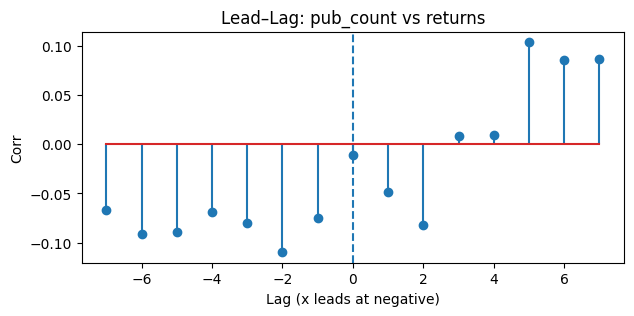

In [8]:
# visualize lead/lag correlations
import matplotlib.pyplot as plt
plt.figure(figsize=(7,3))
plt.stem(leadlag["lag"], leadlag["corr"])
plt.axvline(0, linestyle="--"); plt.title("Lead–Lag: pub_count vs returns"); plt.xlabel("Lag (x leads at negative)"); plt.ylabel("Corr")
plt.show()